# Regresión logística - Preprocessing árbol

La idea de este notebook es realizar una predicción mediante regresión logística utilizando las primeras variables seleccionadas por un árbol de decisión.


##### Bibliotecas

In [30]:
# Modelo
from sklearn.linear_model import LogisticRegression

# Preprocessing
import utils
from sklearn.preprocessing import MinMaxScaler

# Búsqueda
from sklearn.model_selection import train_test_split, GridSearchCV

# Metrics
from sklearn.metrics import roc_curve, plot_roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

# Plots
from matplotlib import pyplot as plt
import seaborn as sns

# Otros
import pandas as pd
import numpy as np

In [2]:
df = utils.feature_engineering(utils.get_data())

In [4]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X)
Y = df['tiene_alto_valor_adquisitivo']

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=27)

### El árbol de decisión. Veamos qué variables elegimos

In [6]:
from sklearn.tree import DecisionTreeClassifier
import graphviz
import dtreeviz.trees as dtreeviz

In [15]:
arbol = DecisionTreeClassifier(min_samples_leaf=300, max_depth=5, random_state=27)
arbol.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=300, random_state=27)

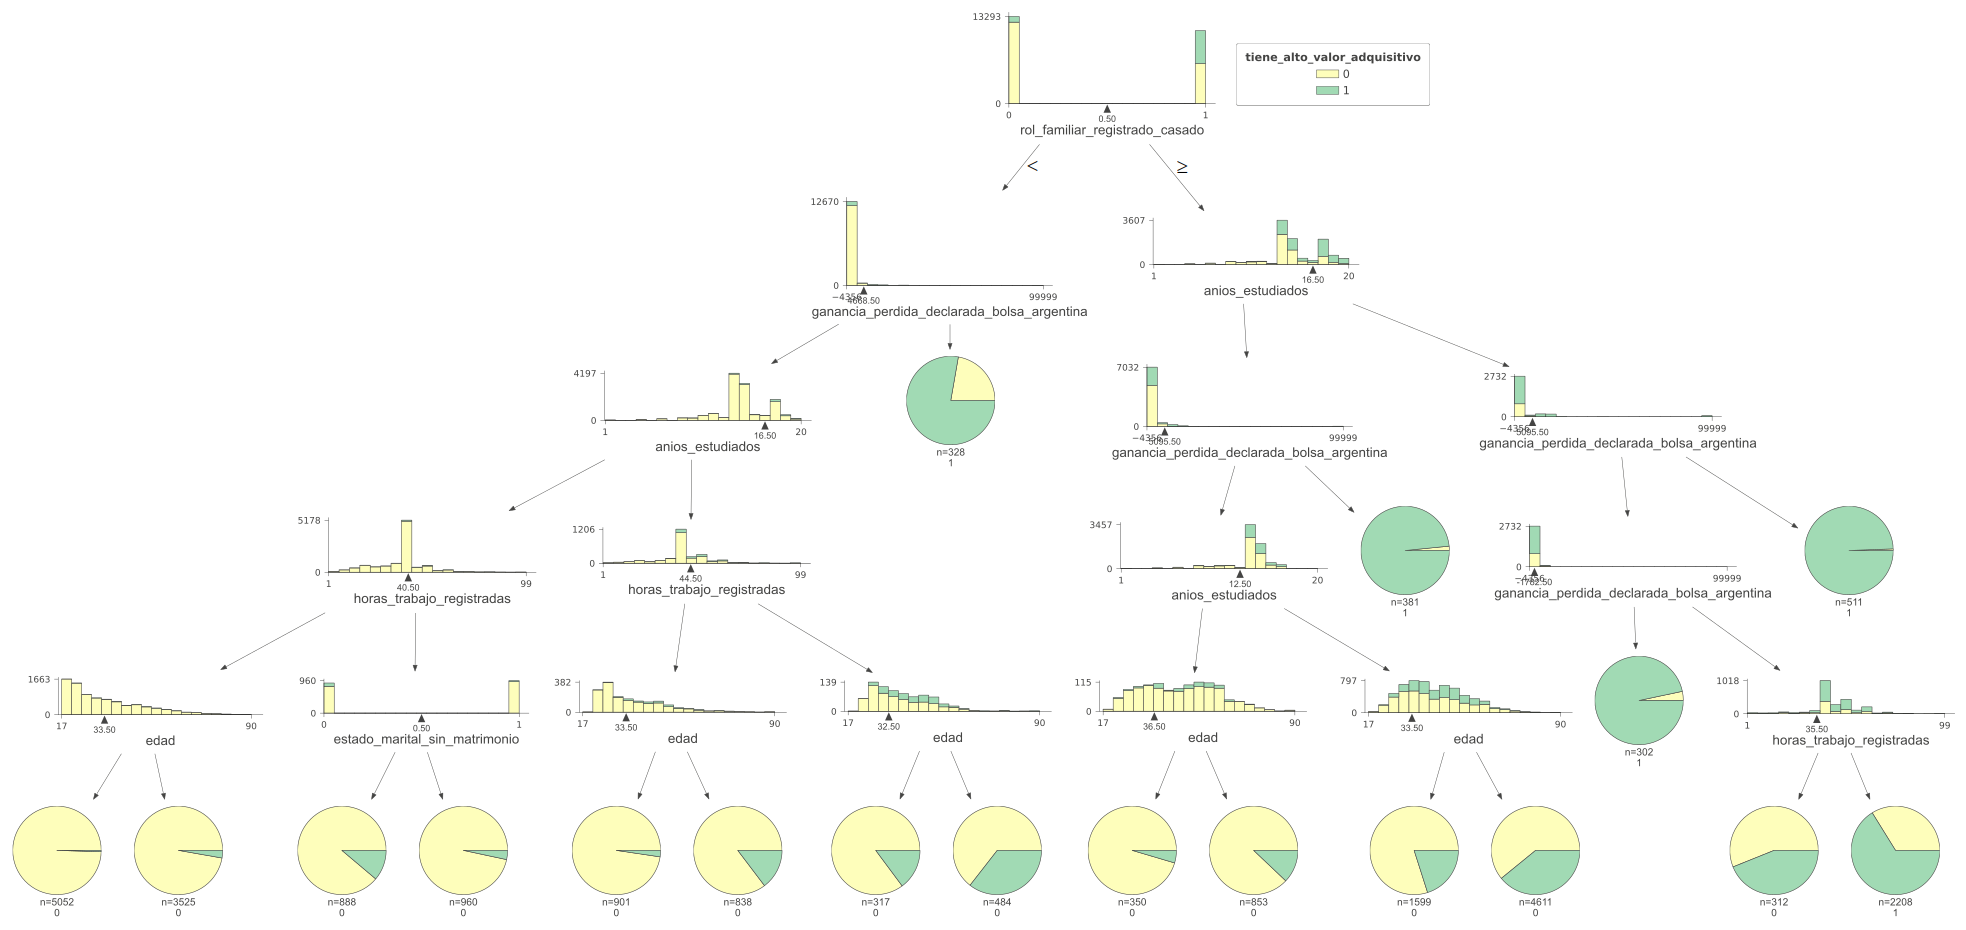

In [16]:
viz = dtreeviz.dtreeviz(
    arbol,
    X_train,
    y_train,
    target_name='tiene_alto_valor_adquisitivo',
    feature_names=list(X.columns),
    class_names=list([0,1]),
    scale=1.5,
)

display(viz)

##### Variables seleccionadas:
(La selección la hacemos nosotors mirando las ganancias en separación con los pieplots)

* Rol familiar registrado.
* Años estudiados.
* ganancia/perdida declarada en la bolsa.
* Edad.
* horas de trabajo registradas.

Por lo que se usarán dichas variables para realizar la regresión, además se escalarán para poder aplicar regularización.

In [ ]:
df['horas_trabajo_registradas']

In [22]:
def filtrar_variables(X):
    seleccion = ['rol_familiar_registrado_casado', 'anios_estudiados', 'ganancia_perdida_declarada_bolsa_argentina', 'edad', 'horas_trabajo_registradas']
    return X[seleccion]

In [23]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X)
X = filtrar_variables(X)
Y = df['tiene_alto_valor_adquisitivo']

# El mismo random_state nos asegura no estar provocando un leaking al seleccionar las variables.
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=27)

## Entrenamiento del modelo

##### Primero se escalan las features

In [43]:
scaler = MinMaxScaler(feature_range=(0,1))

X_train = pd.DataFrame(scaler.fit_transform(X_train)).set_axis(X_train.columns, axis=1)
X_test = pd.DataFrame(scaler.transform(X_test)).set_axis(X_train.columns, axis=1)

##### Búsqueda de hiperparámetros con KFoldCV

In [68]:
model = LogisticRegression(n_jobs=-1, random_state=27)
params = [{'penalty': ['l1']        , 'C': np.logspace(-3, 2, 6), 'solver': ['saga'] },
          {'penalty': ['l2']        , 'C': np.logspace(-3, 2, 6), 'solver': ['lbfgs']},
          {'penalty': ['elasticnet'], 'C': np.logspace(-3, 2, 6), 'solver': ['saga'] , 'l1_ratio': np.linspace(0.1, 0.9, 9)}]

gscv = GridSearchCV(model, params, scoring='roc_auc', n_jobs=-1, cv=10, verbose=4)

In [69]:
gscv.fit(X_train, y_train)

Fitting 10 folds for each of 66 candidates, totalling 660 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 660 out of 660 | elapsed:   43.1s finished


GridSearchCV(cv=10, estimator=LogisticRegression(n_jobs=-1, random_state=27),
             n_jobs=-1,
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'penalty': ['l1'], 'solver': ['saga']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'penalty': ['l2'], 'solver': ['lbfgs']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                          'penalty': ['elasticnet'], 'solver': ['saga']}],
             scoring='roc_auc', verbose=4)

In [70]:
print(gscv.best_estimator_)
print(gscv.best_params_)
print(gscv.best_score_)

LogisticRegression(C=10.0, l1_ratio=0.7000000000000001, n_jobs=-1,
                   penalty='elasticnet', random_state=27, solver='saga')
{'C': 10.0, 'l1_ratio': 0.7000000000000001, 'penalty': 'elasticnet', 'solver': 'saga'}
0.8856746693776454


In [71]:
print(classification_report(y_test,gscv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      6186
           1       0.73      0.55      0.63      1955

    accuracy                           0.84      8141
   macro avg       0.80      0.74      0.76      8141
weighted avg       0.83      0.84      0.83      8141



##### El modelo

In [72]:
modelo = gscv.best_estimator_

modelo.fit(X_train, y_train)

LogisticRegression(C=10.0, l1_ratio=0.7000000000000001, n_jobs=-1,
                   penalty='elasticnet', random_state=27, solver='saga')

In [73]:
modelo.coef_

array([[ 2.41989921,  6.88857901, 24.41163862,  1.90646672,  3.24288057]])

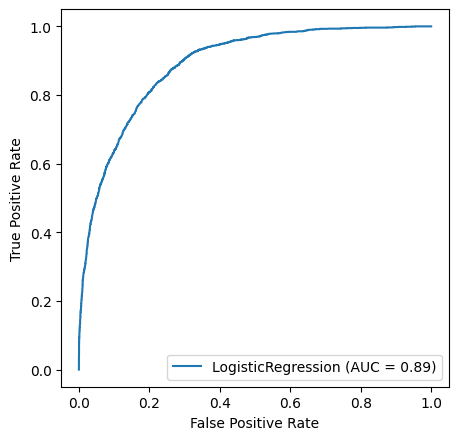

In [75]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
plot_roc_curve(modelo, X_test, y_test, ax=ax)
plt.show()

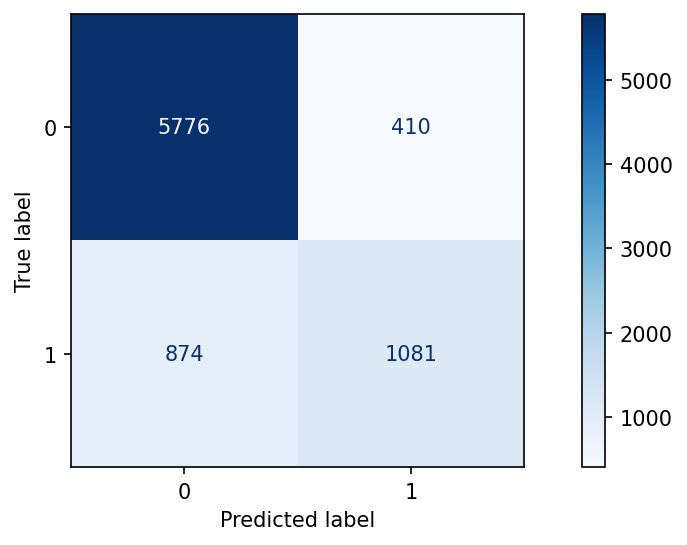

In [76]:
fig, ax = plt.subplots(figsize=(10,4), dpi=150)
plt.grid(False)
plot_confusion_matrix(modelo, X_test, y_test, cmap=plt.cm.Blues, ax=ax)
plt.show()